# Modeling Revenue and forecasting

## EDA of revenue trends

Let's begin with understanding the revenue trends of long standing companies. The questions I have in mind
1. Are there generalizable trends in revenue or growth rate history?
2. Is it possible to group companies based on certain criteria where the revenue trends can be generalized accurately?
3. What is the probability distribution of revenue growth rates at 5,10,15,20,25,30 etc year mark?


It is a good idea to lay down specifically some of the expections  and initial thoughts about the trends I have.

1. Revenue growth rate cannot be increasing forever, so it should follow a quadratic curve. Once the company stabilizes after 10,15,20 years, the growth rates should flatten out
2. Linear regression is not a good method to project revenue or growth rate trends because over long periods of time (10 years), it's hard to say if the company can keep growing with the increasing growth rate
3. If the growth rate should follow a quadratic curve, the rate of growth rate should be linear.


** The plots tell a different story however!

#### Understand the trends of the following metrics

$$Revenue\ Vs\ Time:\ R/T$$ 
$$Revenue\ Growth\ Rate:\ \frac{dR}{dT}$$
$$Rate\ of\ Revenue\ Growth\ Rate:\ \frac{d^2 R}{dT^2}$$ 

--------------------------------------------------------------------------------------------------------------------------------

In [26]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import r2_score,mean_squared_error

from data.scripts.simplified_finance_stats.fin_stats import fin_stats
from data.scripts.simplified_finance_stats.fin_ratios import get_ratios
from data.scripts.simplified_finance_stats.fin_stats_2 import fin_stats_2
from data.scripts.simplified_finance_stats.stock_stats import stock_stats

pd.options.display.max_rows = 999

### Initialize Data

In [27]:
# Set path for data
base_path = '../../data/'
sheets_path = 'combined_simplified/combined_all_us.csv' 
other_path = 'combined_simplified/others_all_us.csv'
mkt_path = 'combined_simplified/stock_stats_all_us.csv'

equity_list_path = '../../equity_list/all_us_list.csv'

In [28]:
# setup all data
finances = fin_stats(base_path + sheets_path)
fin_others = fin_stats_2(base_path + other_path)
mkt_data = stock_stats(base_path + mkt_path)

Total Missing tickers: 181
Total Missing tickers: 181
Total Missing tickers: 181


In [29]:
equity_list = pd.read_csv(equity_list_path)['tick'].tolist()

### Data Preprocessing

For now, only considering companies with more than 30 year history

In [30]:
# Methods for data processing

def get_processed_sheet(tick):
    """Returns processed income sheet with no 0.0 revenue fields"""
    df = finances.get_sheet(tick,"income_sheet")
    revt = df.loc['revt']
    ix = revt[(revt!=0.0)].index.tolist()
    df = df[ix]
    return df

def get_time_hist(tick):
    """Returns the number of years the company has been listed on stock exchange"""
    df = get_processed_sheet(tick)
    return df.shape[1]


In [31]:
# Create a list of equities with 30 year or more of historical data

equity_list_30_yr = []

for i,tick in enumerate(equity_list):
    try:
        if get_time_hist(tick) > 30:
            equity_list_30_yr.append(tick)
    
    except:
        pass
        
print("Number of companies with atleast 30 year history: %i"%len(equity_list_30_yr))
    

AFP not found in income_sheet
CWTR not found in income_sheet
CTYN not found in income_sheet
CWE not found in income_sheet
CNF not found in income_sheet
CTC not found in income_sheet
DOW not found in income_sheet
DOYL not found in income_sheet
EK not found in income_sheet
HB not found in income_sheet
ICX not found in income_sheet
KLU not found in income_sheet
KES not found in income_sheet
KRN not found in income_sheet
MOB not found in income_sheet
MMED not found in income_sheet
NAS not found in income_sheet
GAS not found in income_sheet
OMAH not found in income_sheet
OVT not found in income_sheet
PICN not found in income_sheet
PINK not found in income_sheet
PITS not found in income_sheet
RJR not found in income_sheet
RLM not found in income_sheet
SAFC not found in income_sheet
SPC not found in income_sheet
SY not found in income_sheet
SNS not found in income_sheet
VSTA not found in income_sheet
WPO not found in income_sheet
WSC not found in income_sheet
Z not found in income_sheet
ACD n

### $$Revenue\ Vs\ Time:\ R/T$$

Visualized the revenue trends.
It is observed there are no specific trends. To plot the figure, uncomment the plotting parts in the following section


As expected, plotting revenue plots of 1000 companies, doesn't give any insights on the general trends.

### $$Revenue\ Growth\ Rate:\ \frac{dR}{dT}$$

In [32]:
# Visualizing the distribution of growth rates at uniform time intervals since the start of the company. In this case they are
# [5,10,15,20,25,30] year intervals. 

start_year = 4
end_year = 29
num_intervals = (end_year+1)/(start_year+1)
time_steps = list(np.linspace(start_year,end_year,num_intervals).astype(int))
n=len(equity_list_30_yr) # Number of companies
growth_rate_mat = np.zeros((n+1,num_intervals))

#plt.figure(figsize=(15,8))
#plt.hold(True)

for i,tick in enumerate(equity_list_30_yr):
    try:
        df = get_processed_sheet(tick).loc['revt']
        gr = df.pct_change().rolling(window=3).mean()
        gr_interval = gr.values[time_steps]
        growth_rate_mat[i,:] = gr_interval
        #df = pd.rolling_mean(df,4)
        #x = df.columns.tolist()[0:30]
        x = np.linspace(1,29,29)
        y = df.values[1:30]
        #plt.plot(x,y,alpha=0.5)
        #plt.ylim()
        
    except:
        print i,tick
        break


In [33]:
# Growth rate at different time intervals
df_grw_rate = pd.DataFrame(growth_rate_mat)
df_grw_rate.columns = [i+1 for i in time_steps]
df_grw_rate.head()

,5,10,15,20,25,30
0,0.014481,0.082957,0.183419,0.149682,0.187248,0.157694
1,0.152155,0.129999,0.125884,-0.071414,-0.022430,0.081947
2,0.022024,0.054887,0.347718,-0.073902,0.455520,0.011870
3,-0.044372,0.027117,0.110801,-0.024669,0.353071,0.140053
4,0.048737,0.032052,0.143611,0.147572,0.314755,0.174299


### Distribution of growth rates at time intervals

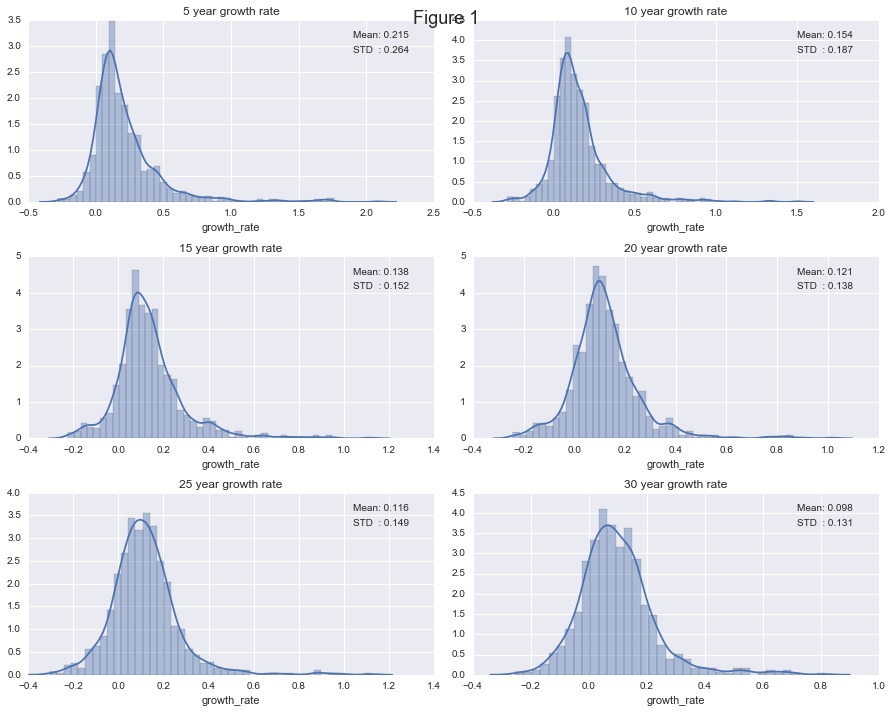

In [36]:
def rmv_outliers(x,perc_1=0.5,perc_2=99):
    """ Removes the outliers based on the given percentiles"""
    
    p1,p2 = np.percentile(x,[perc_1,perc_2])
    x2 = x[np.logical_and(x>=p1,x<=p2)]
    return x2

fig, ax = plt.subplots(3,2)
fig.set_size_inches(12.5,10)
fig.suptitle("Figure 1",fontsize=18)

# loop through the plots
c = 0

for i in range(3):
    for j in range(2):
        data=rmv_outliers(df_grw_rate[time_steps[c]+1].values)
        sns.distplot(data,ax=ax[i,j])
        ax[i,j].set_title("%s year growth rate"%str(time_steps[c]+1))
        ax[i,j].set_xlabel("growth_rate")
        ax[i,j].annotate("Mean: " + "%1.3f"%np.mean(data),xy=(0.8, 0.9), xycoords='axes fraction')
        ax[i,j].annotate("STD  : " + "%1.3f"%np.std(data),xy=(0.8, 0.82), xycoords='axes fraction')
        c += 1

plt.tight_layout()

*********************************************************************************************************************************
Revenue growth at any interval is normally distributed. As expected, the mean revenue growth rate decreases with time
*********************************************************************************************************************************

### CDF of Growth Rates

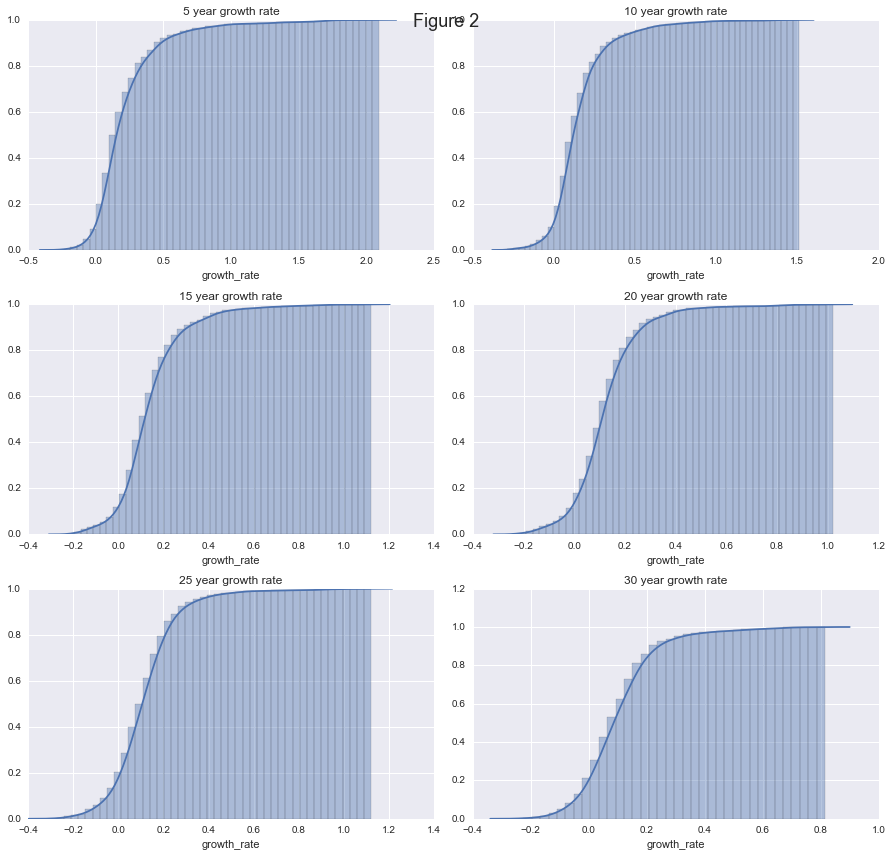

In [39]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12.5,12)
fig.suptitle("Figure 2",fontsize=18)

# loop through the plots
c = 0

for i in range(3):
    for j in range(2):
        sns.distplot(rmv_outliers(df_grw_rate[time_steps[c]+1].values),hist_kws=dict(cumulative=True),
                     kde_kws=dict(cumulative=True),ax=ax[i,j])
        ax[i,j].set_title("%s year growth rate"%str(time_steps[c]+1))
        ax[i,j].set_xlabel("growth_rate")
        c += 1

plt.tight_layout()

### Mean revenue growth rate over time

We would like to see how the mean of revenue growth across different companies changes with time. From common sense we know, the growth rates decrease over time (most likely qudratically). Once confirmed, we can model our growth rate projections using quadratic model.

In [52]:
start_year = 0
end_year = 29
num_intervals = 30
time_steps = list(np.linspace(start_year,end_year,num_intervals).astype(int))
n=len(equity_list_30_yr) # Number of companies
growth_rate_mat = np.zeros((n+1,num_intervals))

for i,tick in enumerate(equity_list_30_yr):
    try:
        df = get_processed_sheet(tick).loc['revt']
        gr = df.pct_change().rolling(window=3).mean()
        gr_interval = gr.values[time_steps]
        growth_rate_mat[i,:] = gr_interval

    except:
        print i,tick
        break

# Growth rate at different time intervals
df_grw_r_all = pd.DataFrame(growth_rate_mat)
df_grw_r_all.columns = [i+1 for i in time_steps]
df_grw_r_all = df_grw_r_all.dropna(axis=1)

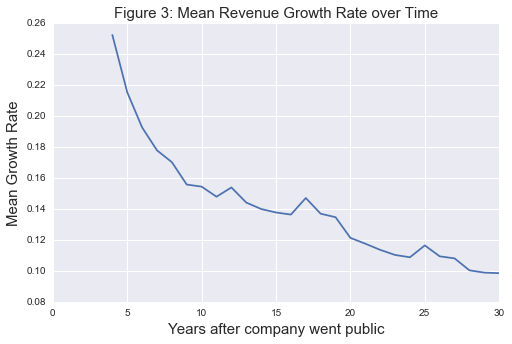

In [12]:
# Plotting the growth rate over time

mean_grw_r = {}
for i,year in enumerate(df_grw_r_all.columns.tolist()):
    y_tmp = rmv_outliers(df_grw_r_all[year].values)
    mean_grw_r[year] = np.mean(y_tmp)
    
x,y = mean_grw_r.keys(),mean_grw_r.values()   
plt.figure(figsize=(8,5))
plt.plot(x,y);
plt.title("Figure 3: Mean Revenue Growth Rate over Time",fontsize=15);
plt.xlabel("Years after company went public",fontsize=15);
plt.ylabel("Mean Growth Rate",fontsize=15);


*********************************************************************************************************************************
Observation: On average the revenue growth rate follows a quadratic curve (as suspected)
*********************************************************************************************************************************

This answers the question of trends in the historical data. Growth rates are more reasonable to predict and are generalizable to a certain extent. We can try to fit a quadratic model to forecast growth rate based on the company timeline.

### Box Plot of growth rates at every year

In [13]:
df_tmp = df_grw_r_all.copy()
for i,year in enumerate(df_tmp.columns.tolist()):
    zz = df_tmp[year].values
    zz = np.sort(zz)
    df_tmp[year] = zz

df_tmp = df_tmp.loc[4:885].reset_index(drop=True)

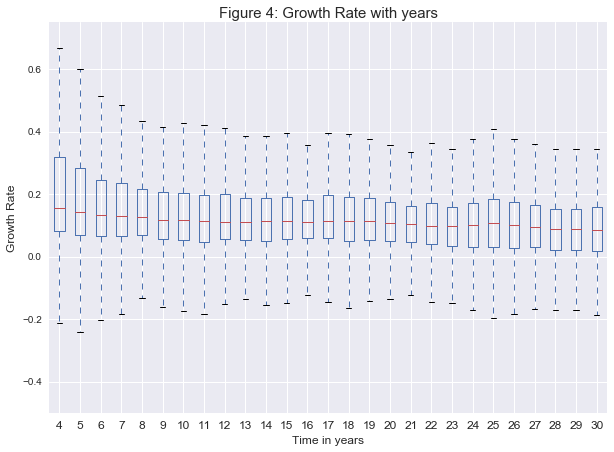

In [14]:
plt.figure(figsize=(10,7))
ax = df_tmp.boxplot(return_type='axes');
ax.set_ylim(-0.5,0.75);
ax.set_title('Figure 4: Growth Rate with years',fontsize=15);
ax.set_ylabel("Growth Rate",fontsize=12)
ax.set_xlabel("Time in years",fontsize=12);


*********************************************************************************************************************************
Observation:
The median growth rate value doesn't change as quadratically as the mean value shown the previous figure. This is because of the variance in the data. While it is true, generally the growth rate decreases over time, it cannot be concluded that this trend is followed by a randomly picked company. We can plot regression lines and see if there are any particular trends.
*********************************************************************************************************************************

### Regression lines of growth rates for all companies

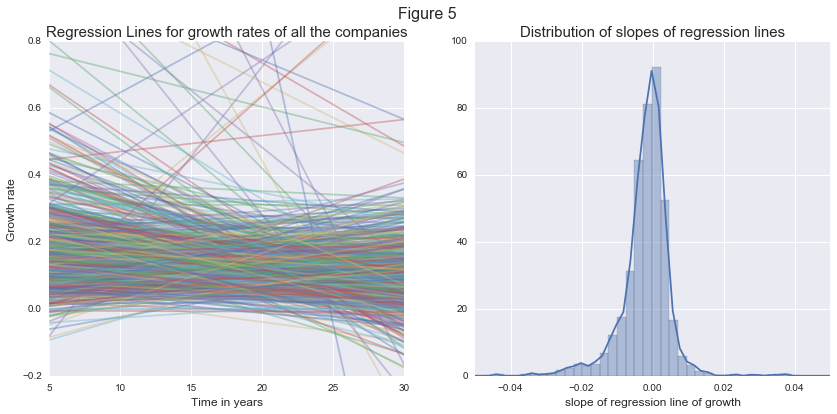

In [51]:
# Plot linear regression lines

def rmv_outliers_w_indices(x,perc_1=10,perc_2=90):
    """ Removes the outliers based on the given percentiles. Returns the array and indices of kept values"""
    
    p1,p2 = np.percentile(x,[perc_1,perc_2])
    ix = np.argwhere(np.logical_and(x>=p1,x<=p2))
    x2 = x[np.logical_and(x>=p1,x<=p2)]
    return x2,np.ravel(ix)

x = np.array(df_grw_r_all.columns.tolist())
slope = []
r2score = []
r2score_2 = []
mse = []

fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,6)
fig.suptitle("Figure 5",fontsize=16)

for i in range(df_grw_r_all.shape[0]):
    y, ix = rmv_outliers_w_indices(df_grw_r_all.loc[i].values)
    # Linear Fit
    coeffs = np.polyfit(x[ix],y,1)
    slope.append(coeffs[0])
    p = np.poly1d(coeffs)
    r2score.append(r2_score(y,p(x[ix])))
    
    # Quadratic Fit
    coeffs_2 = np.polyfit(x[ix],y,2)
    p2 = np.poly1d(coeffs_2)
    r2score_2.append(r2_score(y,p2(x[ix])))
    
    mse.append(mean_squared_error(y,p(x[ix])))
    ax[0].plot(x,p(x),alpha=0.4)
    ax[0].set_ylim(-0.2,0.8)

# Regression Line Plot details    
ax[0].set_title("Regression Lines for growth rates of all the companies",fontsize=15) 
ax[0].set_xlabel("Time in years",fontsize=12)
ax[0].set_ylabel("Growth rate",fontsize=12)
ax[0].set_xlim(5,30)

# Slope distribution
sns.distplot(slope,bins=100,ax=ax[1])
ax[1].set_xlim(-0.05,0.05)
ax[1].set_title("Distribution of slopes of regression lines",fontsize = 15)
ax[1].set_xlabel("slope of regression line of growth",fontsize = 12)

slope = np.array(slope)
r2score = np.array(r2score)
r2score_2 = np.array(r2score_2)
mse = np.array(mse)
    

*********************************************************************************************************************************
Observation:

The slopes are both positive and negative. This is contrary to my expectation that growth rates would decrease over time (negative slope). In the distribution of slopes on the right, you can see that the slopes are distributed both on positive and negative sides. There is no obvious concentration on one side.

In other words, we have a collection of companies who growth rates have increased with time as well as decreased. The latter is expected. To make sense of the increasing growth rates, it is possible that over long periods of time, technological changes have helped companies to expand at a positive rate. Also, with the general economic expansion of the United States, it is quite possible for many companies to keep growing their growth rates
*********************************************************************************************************************************

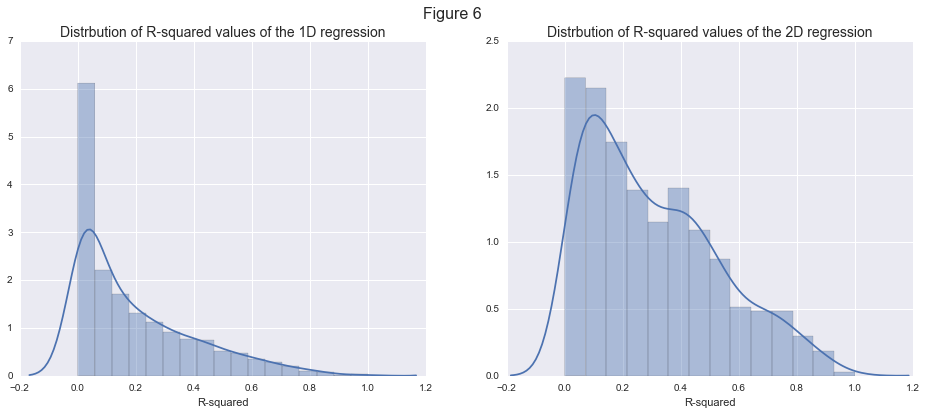

In [44]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)
fig.suptitle("Figure 6",fontsize=16)

# subplot 1
sns.distplot(r2score,ax=ax[0]);
ax[0].set_title("Distrbution of R-squared values of the 1D regression",fontsize=14);
ax[0].set_xlabel("R-squared");

# subplot 2
sns.distplot(r2score_2,ax=ax[1]);
ax[1].set_title("Distrbution of R-squared values of the 2D regression",fontsize=14);
ax[1].set_xlabel("R-squared");


*********************************************************************************************************************************
If we look at the distribution of R-squared values to see how good the regression fits the data, it obvious that, only few companies have a good fit (R-squred > 0.7). Moreover, quadratic fit (on the right) seems better than the linear fit. But since most R-squared values are less than 0.5 in both cases, it's hard to say if they are generalizable. Different order fits will be applicable to different companies as every company has its own unique characteristics.
*********************************************************************************************************************************

--------------------------------------------------------------------------------------------------------------------------------
Conclusion
--------------------------------------------------------------------------------------------------------------------------------

A trend for growth rate of companies cannot be generalized. From figure 3, it can seen in general that the mean growth rate of companies decreases over time, it doesn't necessarily apply to individual companies.

Regression can give some idea about the trend line for individual company, but looking at the R-squared values which indicate the goodness of fit, I am unsure, if regression would give a satisfactory prediction. It is true, it works well for some companies with little variance and stable revenue growth rates, but majority of comapnies have that characteristic.

If we observe the individual plots of growth rates of companies, we can observe the cyclical nature of growth rates irrespective of the regression of trend line. This suggests, ARIMA models should be used and compared with the regression techniques. Below, the plot of rate of revenue growth rate, shows ARIMA models might be a good tool

### $$Rate\ of\ Revenue\ Growth\ Rate:\ \frac{d^2 R}{dT^2}$$ 

Perfrom a similar EDA analysis on rate of revenue growth rate

In [19]:
# Build df of rate of growth rate
df_rgr = df_grw_r_all.pct_change(axis=1)
df_rgr = df_rgr.drop(labels=4,axis=1)
ix_to_rmv = df_rgr[df_rgr.isnull().sum(axis=1)>1].index.tolist() # remove nans
df_rgr = df_rgr.drop(ix_to_rmv,axis=0)

In [21]:
def rmv_outliers_2(x,perc_1=2,perc_2=98):
    """ Removes the outliers based on the given percentiles"""
    
    p1,p2 = np.percentile(x,[perc_1,perc_2])
    x2 = x[np.logical_and(x>=p1,x<=p2)]
    return x2

rgr_mean = {}

for i,year in enumerate(df_rgr.columns.tolist()):
    
    rgr = rmv_outliers_2(df_rgr[year].values)
    rgr_mean[year] = np.mean(rgr)
    #sns.distplot(rgr)
    #plt.savefig("%i.png"%year)
    #plt.clf()

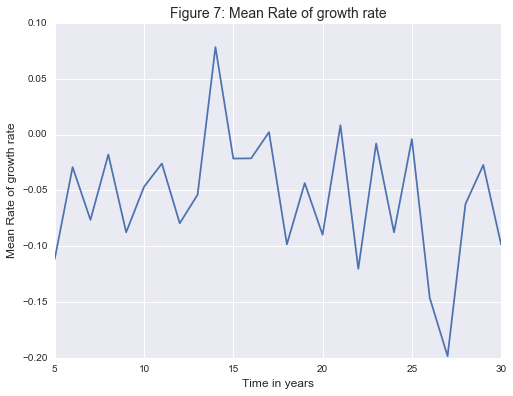

In [49]:
x2,y2 = rgr_mean.keys(),rgr_mean.values()
plt.figure(figsize=(8,6))
plt.plot(x2,y2)
plt.title("Figure 7: Mean Rate of growth rate",fontsize=14)
plt.ylabel("Mean Rate of growth rate",fontsize=12)
plt.xlabel("Time in years",fontsize=12);

Observation:

I was assuming that growth rate would be quadratic and hence the rate of growth rate should be linear. Since my initial assumption was wrong, my hypothesis for rate of growth rate is not true. Rate of growth rate seems cyclical and since it is the second order difference of revenue, ARIMA models should be used to analyze the growth rate and rate of growth rate.